In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
dir_path = '/content/gdrive/My Drive/Colab/'

df = pd.read_csv(dir_path+"processed_1stNov.csv") #  processed_1stNov.csv   final train
df.shape

(1482535, 10)

In [ ]:
y = df['log_price']
df.drop('log_price', axis=1, inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,item_condition_id,brand_name,shipping,Category,Sub_Category_1,Sub_Category_2,combined
0,0,0,3,mlb,1,Men,Tops,T-shirts,mlb cincinnati red t shirt size xl descript yet
1,1,1,3,razer,0,Electronics,Computers & Tablets,Components & Parts,razer blackwidow chroma keyboard keyboard grea...
2,2,2,1,target,1,Women,Tops & Blouses,Blouse,avaviv blous ador top hint lace key hole back ...
3,3,3,1,missing,1,Home,Home Décor,Home Décor Accents,leather hors statu new tag leather hors retail...
4,4,4,1,missing,0,Women,Jewelry,Necklaces,24k gold plate rose complet certif authent


In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(df, y, test_size=0.3, random_state=0)

del(df)
del(y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_cv:", X_cv.shape)

print("Shape of Y_train:", y_train.shape)
print("Shape of Y_cv:", y_cv.shape)

Shape of X_train: (1037774, 9)
Shape of X_cv: (444761, 9)
Shape of Y_train: (1037774,)
Shape of Y_cv: (444761,)


 Text Tokenization and Padding to be used for Embedding Layer


In [ ]:
#finding the appropriate number of words to be used for padding
a = []
for i in X_train['combined']:
  a.append(len(i.split(" ")))

b = []
for i in X_train['brand_name']:
  b.append(len(i.split(" ")))

(array([6.71063e+05, 2.34964e+05, 6.63700e+04, 3.09860e+04, 1.65150e+04,
        1.20440e+04, 4.69300e+03, 1.05900e+03, 7.30000e+01, 7.00000e+00]),
 array([  1. ,  20.3,  39.6,  58.9,  78.2,  97.5, 116.8, 136.1, 155.4,
        174.7, 194. ]),
 <a list of 10 Patch objects>)

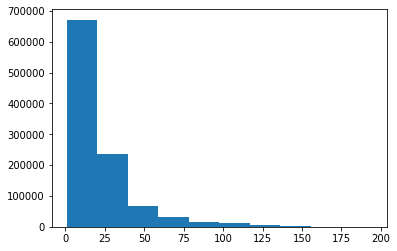

In [ ]:
import matplotlib.pyplot as plt

plt.hist(a)

(array([7.68445e+05, 0.00000e+00, 1.94356e+05, 0.00000e+00, 6.94760e+04,
        0.00000e+00, 5.40300e+03, 0.00000e+00, 8.60000e+01, 8.00000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

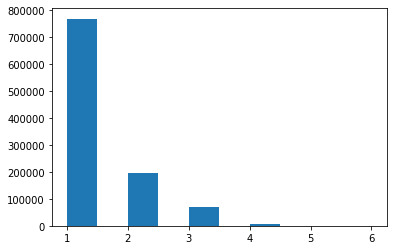

In [ ]:
plt.hist(b)

In [ ]:
#hyperparameters
pad_length_combined = 50
pad_length_brand = 4

In [ ]:
#tokenization for Essay
#https://stackoverflow.com/questions/64158898/what-does-keras-tokenizer-num-words-specify

def tokenize_and_pad(train_corpus, test_corpus, maxlen):

  tokenizer = Tokenizer(oov_token='#OOV#', num_words=None)  #num_words) #num_words=10000
  tokenizer.fit_on_texts(train_corpus)

  train_tokenized = tokenizer.texts_to_sequences(train_corpus)
  train_padded_essay = pad_sequences(train_tokenized, maxlen=maxlen, padding='pre', truncating='pre')
  test_tokenized = tokenizer.texts_to_sequences(test_corpus)
  test_padded = pad_sequences(test_tokenized, maxlen=maxlen, padding='pre', truncating='pre', dtype='int32')

  return train_padded_essay, test_padded, len(tokenizer.word_counts)

In [ ]:
X_train_padded_essay, X_test_padded_essay, num_words_combined = tokenize_and_pad(X_train['combined'], X_cv['combined'], maxlen=pad_length_combined)

In [ ]:
X_train_padded_brand, X_test_padded_brand, num_words_brand = tokenize_and_pad(X_train['brand_name'], X_cv['brand_name'], maxlen=pad_length_brand)

In [ ]:
print(num_words_combined)
print(num_words_brand)
print(X_train_padded_essay.shape)
print(X_train_padded_brand.shape)

245453
4776
(1037774, 50)
(1037774, 4)


Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train[['item_condition_id', 'shipping']])
x_train_num_scaled = scaler.transform(X_train[['item_condition_id', 'shipping']])
x_test_num_scaled = scaler.transform(X_cv[['item_condition_id', 'shipping']])

In [ ]:
x_train_num_scaled.shape

(1037774, 2)

Merging Category and Sub catregories

In [ ]:
X_train['Categories'] = X_train['Category'] + " " + X_train['Sub_Category_1'] + " " + X_train['Sub_Category_2']
X_cv['Categories'] = X_cv['Category'] + " " + X_cv['Sub_Category_1'] + " " + X_cv['Sub_Category_2']

(array([3.27377e+05, 2.03433e+05, 2.13548e+05, 0.00000e+00, 1.95618e+05,
        3.72570e+04, 0.00000e+00, 3.38570e+04, 2.63910e+04, 2.93000e+02]),
 array([ 3. ,  3.7,  4.4,  5.1,  5.8,  6.5,  7.2,  7.9,  8.6,  9.3, 10. ]),
 <a list of 10 Patch objects>)

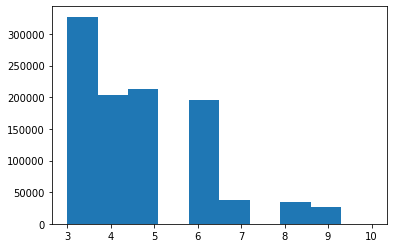

In [ ]:
#getting the length of sentences
a = []
for i in X_train['Categories']:
  a.append(len(i.split(" ")))

plt.hist(a)

We will use 9 as Pad length

In [ ]:
pad_length_category = 9

X_train_padded_category, X_test_padded_category, num_words_category = tokenize_and_pad(X_train['Categories'], X_cv['Categories'], maxlen=pad_length_category)

print(num_words_category)
print(X_train_padded_category.shape)

1007
(1037774, 9)


Model -1 : with only Brand, Name & Description fields with Embedding vector of length 50.

In [ ]:
from tensorflow.keras.layers import LeakyReLU, Dense,Input,Activation,Embedding, Conv1D, Flatten, Concatenate, MaxPool2D,MaxPool1D, LSTM, Dropout, BatchNormalization
from tensorflow.keras.initializers import Constant
from tensorflow.keras.initializers import RandomUniform, HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1,l2

import tensorflow
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, TensorBoard


In [ ]:
#combined
embedding_features = 50

#reason for adding 2 in num_words: 1 for OOV words, 1 because it takes range so range(6) doesn't include 6.. so we add 1

input_combined = Input(shape=(pad_length_combined,))
Combined_Embedding_layer=Embedding(num_words_combined+2, embedding_features, input_length=pad_length_combined, name = 'Combined')(input_combined)
print('Embedding layer:', Combined_Embedding_layer.shape)
lstm_layer = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_combined, embedding_features))(Combined_Embedding_layer)
print('LSTM layer:', lstm_layer.shape)
flatten_0 = Flatten()(lstm_layer)
print("flatten_0", flatten_0.get_shape())

#brand
input_brand = Input(shape=(pad_length_brand,))
Brand_Embedding_layer=Embedding(num_words_brand+2, embedding_features, input_length=pad_length_brand, name = 'Brand')(input_brand)
print('Embedding layer:', Brand_Embedding_layer.shape)
lstm_layer_b = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_brand, embedding_features))(Brand_Embedding_layer)
print('LSTM layer:', lstm_layer_b.shape)
flatten_b = Flatten()(lstm_layer_b)
print("flatten_b", flatten_b.get_shape())

#concatenate
merged = Concatenate(axis=-1)([flatten_0, flatten_b])  #, flatten_4, flatten_1, flatten_2, flatten_5, Dense_6])

Dense2 = Dense(50,activation='relu')(merged)
dropout_1 = Dropout(0.4)(Dense2)
Dense3 = Dense(10,activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(Dense3)

x = BatchNormalization()(dropout_2)

output = Dense(1,activation='relu')(x) #(flatten_0)


Embedding layer: (None, 50, 50)
LSTM layer: (None, 50, 50)
flatten_0 (None, 2500)
Embedding layer: (None, 4, 50)
LSTM layer: (None, 4, 50)
flatten_b (None, 200)


In [ ]:
x = Model(inputs=input_combined, outputs=flatten_0)
y = Model(inputs=input_brand, outputs=flatten_b)

model = Model(inputs=[x.input, y.input], outputs=output)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 Combined (Embedding)           (None, 50, 50)       12272750    ['input_6[0][0]']                
                                                                                                  
 Brand (Embedding)              (None, 4, 50)        238900      ['input_7[0][0]']                
                                                                                            

In [ ]:
x_input = [X_train_padded_essay, X_train_padded_brand]
x_validation = [X_test_padded_essay, X_test_padded_brand]

#https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be
#https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001,decay=1e-8)
model.compile(loss=root_mean_squared_error, optimizer="rmsprop", metrics =["accuracy"])


In [ ]:
model.fit(x=x_input, y=y_train, epochs=4,batch_size=100,
 validation_data=(x_validation,y_cv))
# callbacks=[checkpoint, learning_rate_reduction, history_own, tensorboard_callback])

Epoch 1/4
10378/10378 [==============================] - 1228s 118ms/step - loss: 0.5288 - accuracy: 0.0000e+00 - val_loss: 0.5024 - val_accuracy: 0.0000e+00
Epoch 2/4
10378/10378 [==============================] - 1158s 112ms/step - loss: 0.5188 - accuracy: 0.0000e+00 - val_loss: 0.5320 - val_accuracy: 0.0000e+00
Epoch 3/4
10378/10378 [==============================] - 1142s 110ms/step - loss: 0.5100 - accuracy: 0.0000e+00 - val_loss: 0.5316 - val_accuracy: 0.0000e+00
Epoch 4/4
10378/10378 [==============================] - 1135s 109ms/step - loss: 0.5028 - accuracy: 0.0000e+00 - val_loss: 0.5133 - val_accuracy: 0.0000e+00


Model -2 : Using All features with Embedding vector of length 50.

In [ ]:
tensorflow.keras.backend.clear_session()

In [ ]:
#combined
embedding_features = 50

#reason for adding 2 in num_words: 1 for OOV words, 1 because it takes range so range(6) doesn't include 6.. so we add 1

input_combined = Input(shape=(pad_length_combined,))
Combined_Embedding_layer=Embedding(num_words_combined+2, embedding_features, input_length=pad_length_combined, name = 'Combined')(input_combined)
print('Embedding layer:', Combined_Embedding_layer.shape)
lstm_layer = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_combined, embedding_features))(Combined_Embedding_layer)
print('LSTM layer:', lstm_layer.shape)
flatten_0 = Flatten()(lstm_layer)
print("flatten_0", flatten_0.get_shape())

#brand
input_brand = Input(shape=(pad_length_brand,))
Brand_Embedding_layer=Embedding(num_words_brand+2, embedding_features, input_length=pad_length_brand, name = 'Brand')(input_brand)
print('Embedding layer:', Brand_Embedding_layer.shape)
lstm_layer_b = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_brand, embedding_features))(Brand_Embedding_layer)
print('LSTM layer:', lstm_layer_b.shape)
flatten_b = Flatten()(lstm_layer_b)
print("flatten_b", flatten_b.get_shape())

#categories
input_categories = Input(shape=(pad_length_category,))
Categories_Embedding_layer=Embedding(num_words_category+2, embedding_features, input_length=pad_length_category, name = 'Categories')(input_categories)
print('Categories Embedding layer:', Categories_Embedding_layer.shape)
lstm_layer_c = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_category, embedding_features))(Categories_Embedding_layer)
print('LSTM layer:', lstm_layer_c.shape)
flatten_c = Flatten()(lstm_layer_c)
print("flatten_c", flatten_c.get_shape())

#numerical features
input_numerical = Input(shape=(2,))
Dense_6 = Dense(50,activation='relu', name = 'Dense_Numerical')(input_numerical) #try activation relu

#concatenate
merged = Concatenate(axis=-1)([flatten_0, flatten_b, flatten_c, Dense_6])

x = BatchNormalization()(merged)

Dense2 = Dense(500, activation='relu')(x) #(merged)
dropout_1 = Dropout(0.4)(Dense2)
Dense3 = Dense(100,activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(Dense3)
x = BatchNormalization()(dropout_2)

x = Dense(10,activation='relu')(x) #(flatten_0)
output = Dense(1,activation='relu')(x) #(flatten_0)



x = Model(inputs=input_combined, outputs=flatten_0)
y = Model(inputs=input_brand, outputs=flatten_b)
z = Model(inputs=input_categories, outputs=flatten_c)
w = Model(inputs=input_numerical, outputs=Dense_6)


model = Model(inputs=[x.input, y.input, z.input, w.input], outputs=output)
model.summary()

Embedding layer: (None, 50, 50)
LSTM layer: (None, 50, 50)
flatten_0 (None, 2500)
Embedding layer: (None, 4, 50)
LSTM layer: (None, 4, 50)
flatten_b (None, 200)
Categories Embedding layer: (None, 9, 50)
LSTM layer: (None, 9, 50)
flatten_c (None, 450)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                       

In [ ]:

x_input = [X_train_padded_essay, X_train_padded_brand, X_train_padded_category, x_train_num_scaled]
x_validation = [X_test_padded_essay, X_test_padded_brand, X_test_padded_category, x_test_num_scaled]

filepath= dir_path + "best_model2.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,patience=3, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

#https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be
#https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001,decay=1e-8)
model.compile(loss=root_mean_squared_error, optimizer=opt, metrics = tensorflow.keras.metrics.RootMeanSquaredError())

model.fit(x=x_input, y=y_train, epochs=10, batch_size=128, validation_data=(x_validation,y_cv), callbacks=[checkpoint, earlystop, learning_rate_reduction])

Epoch 1/10
8108/8108 [==============================] - ETA: 0s - loss: 0.5198 - root_mean_squared_error: 0.5258
Epoch 1: val_loss improved from inf to 0.46610, saving model to /content/gdrive/My Drive/Colab/best_model2.h5
8108/8108 [==============================] - 2116s 260ms/step - loss: 0.5198 - root_mean_squared_error: 0.5258 - val_loss: 0.4661 - val_root_mean_squared_error: 0.4682 - lr: 0.0010
Epoch 2/10
8108/8108 [==============================] - ETA: 0s - loss: 0.4550 - root_mean_squared_error: 0.4572
Epoch 2: val_loss improved from 0.46610 to 0.44957, saving model to /content/gdrive/My Drive/Colab/best_model2.h5
8108/8108 [==============================] - 2114s 261ms/step - loss: 0.4550 - root_mean_squared_error: 0.4572 - val_loss: 0.4496 - val_root_mean_squared_error: 0.4517 - lr: 0.0010
Epoch 3/10
8108/8108 [==============================] - ETA: 0s - loss: 0.4235 - root_mean_squared_error: 0.4256
Epoch 3: val_loss improved from 0.44957 to 0.44538, saving model to /conten

Final Validation loss: 0.443

Model 3 -- Using all features but filtering Name & Description features with TF-IDF values.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(X_train['combined'])
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names_out(), idf))


In [ ]:
idf_dict = dict(zip(vectorizer.get_feature_names_out(), idf))

In [3]:
#print({k: v for k, v in idf_dict.items() if v <= 12})

In [ ]:
for i in list(idf_dict.keys()):
 if idf_dict[i]>12:
  idf_dict.pop(i)


In [ ]:
len(idf_dict.keys())

20269

In [ ]:
def filter_text(series):
 
  new_essay = []
 
  for text in series:
  #print(text)
    words = text.split(' ')
    for word in words:
      if idf_dict.get(word,-1)!=-1:
        words.remove(word)
    new_essay.append(' '.join(words))

  return new_essay

X_train_filtered_combined = filter_text(X_train['combined'])
X_test_filtered_combined = filter_text(X_cv['combined'])

(array([7.90794e+05, 1.58982e+05, 4.98700e+04, 2.10510e+04, 1.33530e+04,
        3.23000e+03, 4.47000e+02, 3.80000e+01, 7.00000e+00, 2.00000e+00]),
 array([  1. ,  13.5,  26. ,  38.5,  51. ,  63.5,  76. ,  88.5, 101. ,
        113.5, 126. ]),
 <a list of 10 Patch objects>)

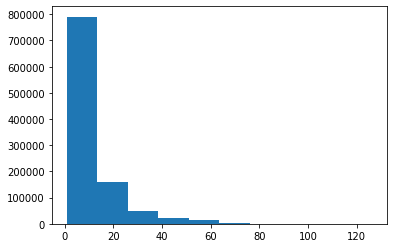

In [ ]:
a = []
for i in X_train_filtered_combined:
  a.append(len(i.split(" ")))

import matplotlib.pyplot as plt
plt.hist(a)

In [ ]:
pad_length_combined = 30

X_train_padded_essay, X_test_padded_essay, num_words_combined = tokenize_and_pad(X_train['combined'], X_cv['combined'], maxlen=pad_length_combined)

In [ ]:
tensorflow.keras.backend.clear_session()

#combined
embedding_features = 50

#reason for adding 2 in num_words: 1 for OOV words, 1 because it takes range so range(6) doesn't include 6.. so we add 1

input_combined = Input(shape=(pad_length_combined,))
Combined_Embedding_layer=Embedding(num_words_combined+2, embedding_features, input_length=pad_length_combined, name = 'Combined')(input_combined)
print('Embedding layer:', Combined_Embedding_layer.shape)
lstm_layer = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_combined, embedding_features))(Combined_Embedding_layer)
print('LSTM layer:', lstm_layer.shape)
flatten_0 = Flatten()(lstm_layer)
print("flatten_0", flatten_0.get_shape())

#brand
input_brand = Input(shape=(pad_length_brand,))
Brand_Embedding_layer=Embedding(num_words_brand+2, embedding_features, input_length=pad_length_brand, name = 'Brand')(input_brand)
print('Embedding layer:', Brand_Embedding_layer.shape)
lstm_layer_b = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_brand, embedding_features))(Brand_Embedding_layer)
print('LSTM layer:', lstm_layer_b.shape)
flatten_b = Flatten()(lstm_layer_b)
print("flatten_b", flatten_b.get_shape())

#categories
input_categories = Input(shape=(pad_length_category,))
Categories_Embedding_layer=Embedding(num_words_category+2, embedding_features, input_length=pad_length_category, name = 'Categories')(input_categories)
print('Categories Embedding layer:', Categories_Embedding_layer.shape)
lstm_layer_c = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_category, embedding_features))(Categories_Embedding_layer)
print('LSTM layer:', lstm_layer_c.shape)
flatten_c = Flatten()(lstm_layer_c)
print("flatten_c", flatten_c.get_shape())

#numerical features
input_numerical = Input(shape=(2,))
Dense_6 = Dense(50,activation='relu', name = 'Dense_Numerical')(input_numerical) #try activation relu

#concatenate
merged = Concatenate(axis=-1)([flatten_0, flatten_b, flatten_c, Dense_6])

x = BatchNormalization()(merged)

Dense2 = Dense(500, activation='relu')(x) #(merged)
dropout_1 = Dropout(0.4)(Dense2)
Dense3 = Dense(100,activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(Dense3)
x = BatchNormalization()(dropout_2)

x = Dense(10,activation='relu')(x) #(flatten_0)
output = Dense(1,activation='relu')(x) #(flatten_0)



x = Model(inputs=input_combined, outputs=flatten_0)
y = Model(inputs=input_brand, outputs=flatten_b)
z = Model(inputs=input_categories, outputs=flatten_c)
w = Model(inputs=input_numerical, outputs=Dense_6)


model = Model(inputs=[x.input, y.input, z.input, w.input], outputs=output)
model.summary()

Embedding layer: (None, 30, 50)
LSTM layer: (None, 30, 50)
flatten_0 (None, 1500)
Embedding layer: (None, 4, 50)
LSTM layer: (None, 4, 50)
flatten_b (None, 200)
Categories Embedding layer: (None, 9, 50)
LSTM layer: (None, 9, 50)
flatten_c (None, 450)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                       

In [ ]:
x_input = [X_train_padded_essay, X_train_padded_brand, X_train_padded_category, x_train_num_scaled]
x_validation = [X_test_padded_essay, X_test_padded_brand, X_test_padded_category, x_test_num_scaled]

dir_path = '/content/gdrive/My Drive/Mercari/'

filepath= dir_path + "best_model_3_tdidf.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001,patience=3, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

#https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be
#https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001,decay=1e-8)
model.compile(loss=root_mean_squared_error, optimizer=opt, metrics = tensorflow.keras.metrics.RootMeanSquaredError())

model.fit(x=x_input, y=y_train, epochs=10, batch_size=128, validation_data=(x_validation,y_cv), callbacks=[checkpoint, earlystop, learning_rate_reduction])

Epoch 1/10
8108/8108 [==============================] - ETA: 0s - loss: 0.5325 - root_mean_squared_error: 0.5516
Epoch 1: val_loss improved from inf to 0.47487, saving model to /content/gdrive/My Drive/Mercari/best_model_3_tdidf.h5
8108/8108 [==============================] - 1734s 213ms/step - loss: 0.5325 - root_mean_squared_error: 0.5516 - val_loss: 0.4749 - val_root_mean_squared_error: 0.4771 - lr: 0.0010
Epoch 2/10
8108/8108 [==============================] - ETA: 0s - loss: 0.4649 - root_mean_squared_error: 0.4672
Epoch 2: val_loss improved from 0.47487 to 0.45886, saving model to /content/gdrive/My Drive/Mercari/best_model_3_tdidf.h5
8108/8108 [==============================] - 1723s 213ms/step - loss: 0.4649 - root_mean_squared_error: 0.4672 - val_loss: 0.4589 - val_root_mean_squared_error: 0.4611 - lr: 0.0010
Epoch 3/10
8108/8108 [==============================] - ETA: 0s - loss: 0.4359 - root_mean_squared_error: 0.4381
Epoch 3: val_loss improved from 0.45886 to 0.45585, savin

Model-4: Trying with Embedding featrues 100 instead of 50 with all features.

In [ ]:
tensorflow.keras.backend.clear_session()

#combined
embedding_features = 100

#reason for adding 2 in num_words: 1 for OOV words, 1 because it takes range so range(6) doesn't include 6.. so we add 1

input_combined = Input(shape=(pad_length_combined,))
Combined_Embedding_layer=Embedding(num_words_combined+2, embedding_features, input_length=pad_length_combined, name = 'Combined')(input_combined)
print('Embedding layer:', Combined_Embedding_layer.shape)
lstm_layer = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_combined, embedding_features))(Combined_Embedding_layer)
print('LSTM layer:', lstm_layer.shape)
flatten_0 = Flatten()(lstm_layer)
print("flatten_0", flatten_0.get_shape())

#brand
input_brand = Input(shape=(pad_length_brand,))
Brand_Embedding_layer=Embedding(num_words_brand+2, embedding_features, input_length=pad_length_brand, name = 'Brand')(input_brand)
print('Embedding layer:', Brand_Embedding_layer.shape)
lstm_layer_b = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_brand, embedding_features))(Brand_Embedding_layer)
print('LSTM layer:', lstm_layer_b.shape)
flatten_b = Flatten()(lstm_layer_b)
print("flatten_b", flatten_b.get_shape())

#categories
input_categories = Input(shape=(pad_length_category,))
Categories_Embedding_layer=Embedding(num_words_category+2, embedding_features, input_length=pad_length_category, name = 'Categories')(input_categories)
print('Categories Embedding layer:', Categories_Embedding_layer.shape)
lstm_layer_c = LSTM(50, activation='relu', return_sequences=True, input_shape=(pad_length_category, embedding_features))(Categories_Embedding_layer)
print('LSTM layer:', lstm_layer_c.shape)
flatten_c = Flatten()(lstm_layer_c)
print("flatten_c", flatten_c.get_shape())

#numerical features
input_numerical = Input(shape=(2,))
Dense_6 = Dense(50,activation='relu', name = 'Dense_Numerical')(input_numerical) #try activation relu

#concatenate
merged = Concatenate(axis=-1)([flatten_0, flatten_b, flatten_c, Dense_6])

x = BatchNormalization()(merged)

Dense2 = Dense(500, activation='relu')(x) #(merged)
dropout_1 = Dropout(0.4)(Dense2)
Dense3 = Dense(100,activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(Dense3)
x = BatchNormalization()(dropout_2)

x = Dense(10,activation='relu')(x) #(flatten_0)
output = Dense(1,activation='relu')(x) #(flatten_0)



x = Model(inputs=input_combined, outputs=flatten_0)
y = Model(inputs=input_brand, outputs=flatten_b)
z = Model(inputs=input_categories, outputs=flatten_c)
w = Model(inputs=input_numerical, outputs=Dense_6)


model = Model(inputs=[x.input, y.input, z.input, w.input], outputs=output)
model.summary()

Embedding layer: (None, 50, 100)
LSTM layer: (None, 50, 50)
flatten_0 (None, 2500)
Embedding layer: (None, 4, 100)
LSTM layer: (None, 4, 50)
flatten_b (None, 200)
Categories Embedding layer: (None, 9, 100)
LSTM layer: (None, 9, 50)
flatten_c (None, 450)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                    

In [ ]:

x_input = [X_train_padded_essay, X_train_padded_brand, X_train_padded_category, x_train_num_scaled]
x_validation = [X_test_padded_essay, X_test_padded_brand, X_test_padded_category, x_test_num_scaled]

dir_path = '/content/gdrive/My Drive/Mercari/'

filepath= dir_path + "best_model4.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,patience=3, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

#https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
#https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be
#https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001,decay=1e-8)
model.compile(loss=root_mean_squared_error, optimizer=opt, metrics = tensorflow.keras.metrics.RootMeanSquaredError())

model.fit(x=x_input, y=y_train, epochs=10, batch_size=128, validation_data=(x_validation,y_cv), callbacks=[checkpoint, earlystop, learning_rate_reduction])

Epoch 1/10
8108/8108 [==============================] - ETA: 0s - loss: 0.5234 - root_mean_squared_error: 0.5354
Epoch 1: val_loss improved from inf to 0.46217, saving model to /content/gdrive/My Drive/Mercari/best_model4.h5
8108/8108 [==============================] - 3183s 392ms/step - loss: 0.5234 - root_mean_squared_error: 0.5354 - val_loss: 0.4622 - val_root_mean_squared_error: 0.4643 - lr: 0.0010
Epoch 2/10
8108/8108 [==============================] - ETA: 0s - loss: 0.4528 - root_mean_squared_error: 0.4550
Epoch 2: val_loss improved from 0.46217 to 0.44971, saving model to /content/gdrive/My Drive/Mercari/best_model4.h5
8108/8108 [==============================] - 3298s 407ms/step - loss: 0.4528 - root_mean_squared_error: 0.4550 - val_loss: 0.4497 - val_root_mean_squared_error: 0.4518 - lr: 0.0010
Epoch 3/10
8108/8108 [==============================] - ETA: 0s - loss: 0.4206 - root_mean_squared_error: 0.4227
Epoch 3: val_loss improved from 0.44971 to 0.44488, saving model to /co

In [2]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "CV Loss"]

table.add_row(['Model -1 : with only Brand, Name & Description fields with Embedding vector of length 50.','0.5'])
table.add_row(['Model -2 : Using All features with Embedding vector of length 50.','0.443'])
table.add_row(['Model -3 : Using all features but filtering Name & Description features with TF-IDF values.','0.452'])
table.add_row(['Model-4: Trying with Embedding featrues 100 instead of 50 with all features.','0.441'])

print(table)

+---------------------------------------------------------------------------------------------+---------+
|                                            Model                                            | CV Loss |
+---------------------------------------------------------------------------------------------+---------+
|  Model -1 : with only Brand, Name & Description fields with Embedding vector of length 50.  |   0.5   |
|              Model -2 : Using All features with Embedding vector of length 50.              |  0.443  |
| Model -3 : Using all features but filtering Name & Description features with TF-IDF values. |  0.452  |
|         Model-4: Trying with Embedding featrues 100 instead of 50 with all features.        |  0.441  |
+---------------------------------------------------------------------------------------------+---------+
